# California Housing Prices
The original dataset appeared in R. Kelley Pace and Ronald Barry, “Sparse Spatial Autoregressions,” Statistics
& Probability Letters 33, no. 3 (1997): 291–297.

The first question is what exactly is the business objective; building a
model is probably not the end goal. How does the company expect to use and benefit
from this model? This is important because it will determine how you frame the
problem, what algorithms you will select, what performance measure you want.


The next question to ask is what the current solution looks like (if any). It will often
give you a reference performance, as well as insights on how to solve the problem.

### Frame the Problem

 It is clearly a typical supervised learning task
since you are given labeled training examples (each instance comes with the expected
output, i.e., the district’s median housing price). 

Moreover, it is also a typical regres
sion task, since you are asked to predict a value. More specifically, this is a multivari
ate regression problem since the system will use multiple features to make a prediction
(it will use the district’s population, the median income, etc.).
 
 Finally, there is no continuous flow of data coming in
the system, there is no particular need to adjust to changing data rapidly, and the data
is small enough to fit in memory, so plain batch learning should do just fine.

### Select a Performance Measure

Your next step is to select a performance measure. A typical performance measure for
regression problems is the Root Mean Square Error (RMSE). It measures the standard
deviation4
 of the errors the system makes in its predictions. 

### Check the Assumptions

It is good practice to list and verify the assumptions that were made so far (by you or others); this can catch serious issues early on.

For example, the district prices that your system outputs are going to be fed into a downstream Machine Learning system, and we assume that these prices are going to be used as such. But what if the downstream system actually converts the prices into categories (e.g., “cheap,” “medium,” or “expensive”) and then uses those categories instead of the prices themselves? In this case, getting the price perfectly right is not important at all; your system just needs to get the category right. If that’s so, then the problem should have been framed as a classification task, not a regression task. You don’t want to find this out after working on a regression system for months.

### Get the Data
Let’s load the data using Pandas

In [1]:
import pandas as pd
import os
#Path where data is stored

PATH = os.path.join(os.getcwd(),"data")
#Function for loading the dataset
def load_housing_data(path = PATH):
    csv_path = os.path.join(path,"housing.csv")
    return pd.read_csv(csv_path)
    
    

### Take a Quick Look at the Data Structure
Let’s take a look at the top five rows using the DataFrame’s head() method 

In [2]:
housing_data = load_housing_data()
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The info() method is useful to get a quick description of the data, in particular the
total number of rows, and each attribute’s type and number of non-null values 

In [4]:

housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is fairly small by
Machine Learning standards, but it’s perfect to get started. Notice that the total_bed
rooms attribute has only 20,433 non-null values, meaning that 207 districts are miss‐
ing this feature. We will need to take care of this later.


All attributes are numerical, except the ocean_proximity field. Its type is object, so it
could hold any kind of Python object, but since you loaded this data from a CSV file
you know that it must be a text attribute. When you looked at the top five rows, you
probably noticed that the values in that column were repetitive, which means that it is
probably a categorical attribute. You can find out what categories exist and how many
districts belong to each category by using the value_counts() method:

In [5]:
housing_data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The describe() method shows a summary of the
numerical attributes 

In [6]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Lets plot a histogram for each numeric attribute

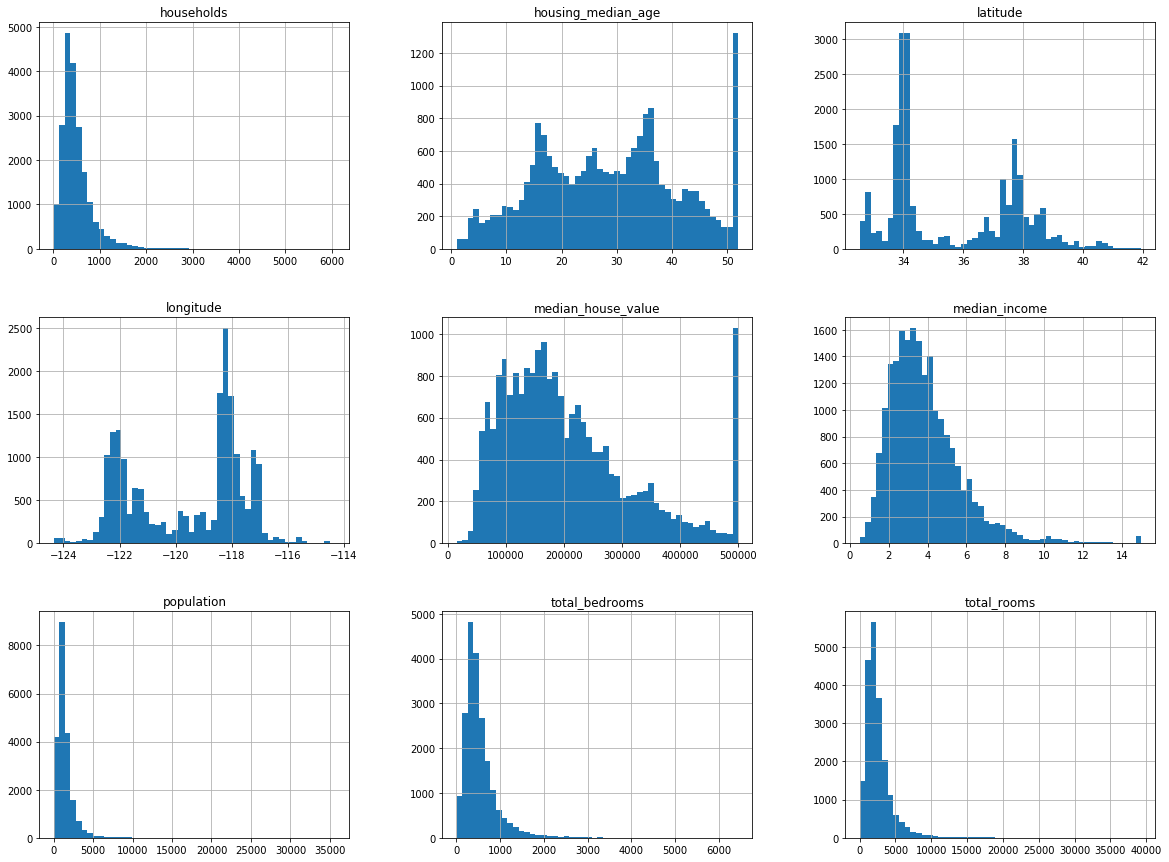

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt 

#creating histogram for each numeric attribute
housing_data.hist(bins = 50 ,
                 figsize= (20,15))

plt.show()


### Conclsuions:

1. Median Income attribute has been scaled and cappedat 15.

2. Median Age and Medain_house_value has also been capped.Sice median_house_value is a label, so our model may learn that prices never go beyond that limit.We need to take care of that too.

3. All these attributes are in different scales. Feature scaling is needed

4. Many histogram are tail heavily i.e. left skewed. So we need to convert them to a bell-shaped distribution. 

#### Wait! Before you look at the data any further, you need to create a test set, put it aside, and never look at it.

### Crating a test datset

In [8]:
#importing necessary module
from sklearn.model_selection import train_test_split
train_set , test_set = train_test_split(housing_data,
                                        random_state = 42,
                                        test_size = 0.2)

So far we have considered purely random sampling methods. This is generally fine if
your dataset is large enough (especially relative to the number of attributes), but if it
is not, you run the risk of introducing a significant sampling bias. 

Since the median income is a very important attribute to predict median housing prices. You may want to ensure that
the test set is representative of the various categories of incomes in the whole dataset.




In [9]:
import numpy as np
housing_data["income_cat"] = np.ceil(housing_data["median_income"]/1.5)

#merging all the categories greater than 5 into category 5:
housing_data["income_cat"].where(housing_data["income_cat"]<5,5.0,inplace = True) 

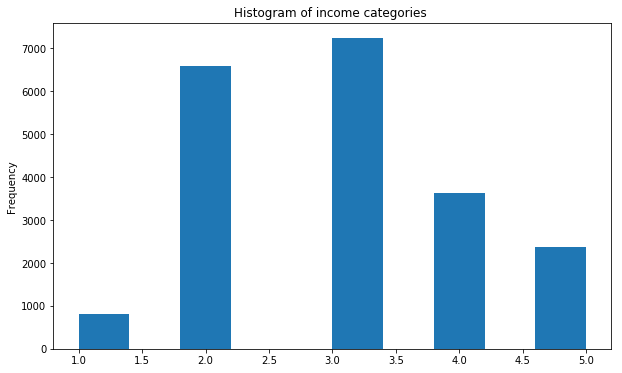

In [10]:
#plotting the histogram for income_cat 
housing_data["income_cat"].plot(kind = "hist",
                             figsize =(10,6))
plt.title("Histogram of income categories ")
plt.show()

Now you are ready to do stratified sampling based on the income category. For this you can use Scikit-Learn’s StratifiedShuffleSplit class:


In [11]:
#importing necessary modules
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1,
                               test_size = 0.2,
                               random_state = 42)

for train_index,test_index in split.split(housing_data,housing_data["income_cat"]):
    strat_train_set =housing_data.loc[train_index] 
    strat_test_set = housing_data.loc[test_index]

Now you are ready to do stratified sampling based on the income category. For this you can use Scikit-Learn’s StratifiedShuffleSplit class:


In [12]:
# Proportion of income category on the total dataset
housing_data["income_cat"].value_counts()/len(housing_data)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [13]:
# Proportion of income category on the tarin dataset
strat_train_set["income_cat"].value_counts()/len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [14]:
# Proportion of income category on the test dataset
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Now remove the income_cat attribute

In [15]:
for sets in (strat_train_set,strat_test_set):
    sets.drop(["income_cat"],axis = 1,inplace = True)

### Discover and Visualize the Data to Gain Insights

In [16]:
#Let’s create a copy so you can play with it without harming the training set
housing = strat_train_set.copy()

### Visualizing Geographical Data
Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data 

Text(0,0.5,'Latitude')

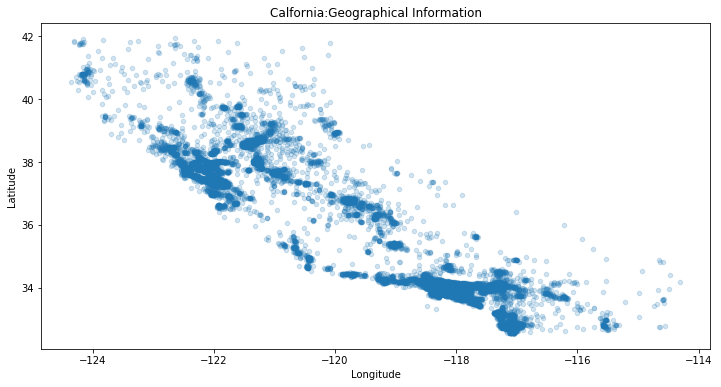

In [17]:
#Scatter Plot for Latitude and Longitude
housing.plot(kind = "scatter",
            figsize  = (12,6),
            alpha = 0.2,
            x="longitude",
            y = "latitude")

plt.title("Calfornia:Geographical Information")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

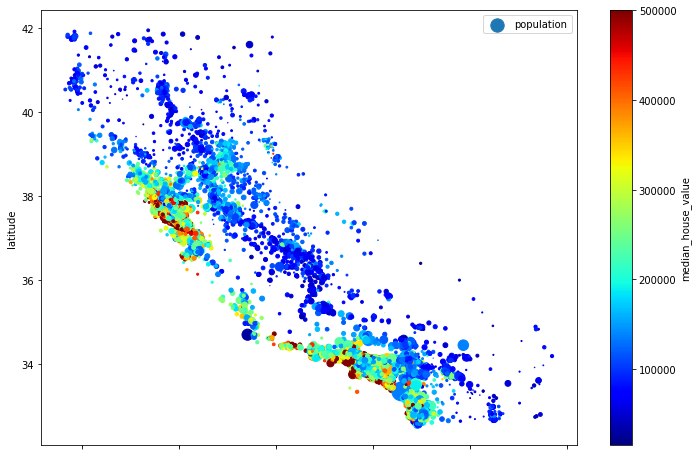

In [18]:
housing.plot(kind = "scatter",
            figsize= (12,8),
            x = "longitude",
            y = "latitude",
            s = housing["population"]/100,
            label = "population",
            c = "median_house_value",
            cmap = plt.get_cmap("jet"),
            colorbar = True
            )
plt.legend()


This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density

### Looking for Correlations


Lets compute the standard correlationcoefficient (also called Pearson’s r) between every pair of attributes using the corr() method

In [19]:
corr_matrix = housing.corr()

Now let’s look at how much each attribute correlates with the median house value

In [20]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Another way to check for correlation between attributes is to use Pandas’
scatter_matrix function, which plots every numerical attribute against every other
numerical attribute. Since there are now 11 numerical attributes, you would get 11square = 121  plots, which would not fit on a page, so let’s just focus on a few promising
attributes that seem most correlated with the median housing value 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BE58F3A6D8>,
      dtype=object)

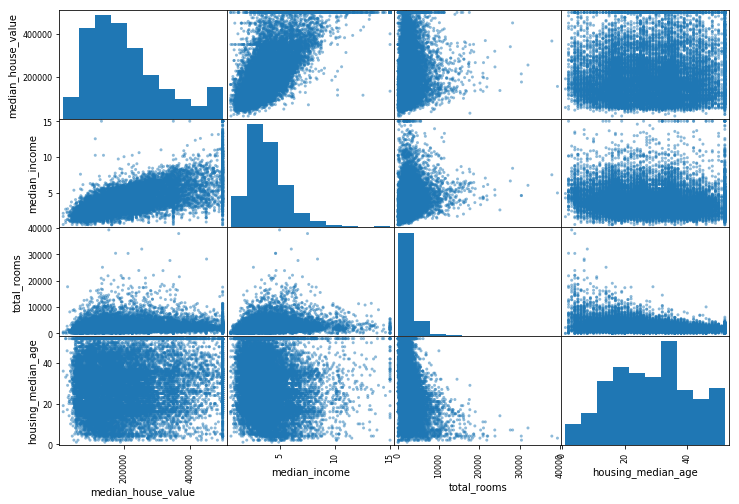

In [21]:
#import necessary modules 
from pandas.plotting import scatter_matrix

#promising attribut
attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]

#plotting the histograms
scatter_matrix(housing[attributes],
              figsize =(12,8))


The main diagonal (top left to bottom right) would be full of straight lines if Pandas
plotted each variable against itself, which would not be very useful. So instead Pandas
displays a histogram of each attribute 

The most promising attribute to predict the median house value is the median
income, so let’s zoom in on their correlation scatterplot 

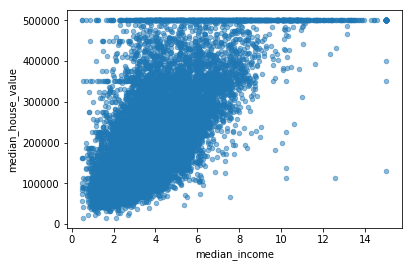

In [22]:
#Plotting histogram with x = median_income and y= median_house_value
housing.plot(kind = "scatter",
            x ="median_income",
            y = "median_house_value",
            alpha = 0.5)

This plot reveals a few things. First, the correlation is indeed very strong; you can
clearly see the upward trend and the points are not too dispersed. Second, the price
cap that we noticed earlier is clearly visible as a horizontal line at  500,000. But this
plot reveals other less obvious straight lines: a horizontal line around 450,000,
another around $ 350,000, perhaps one around 280,000, and a few more below that.
You may want to try removing the corresponding districts to prevent your algorithms
from learning to reproduce these data quirks.

### Experimenting with Attribute Combinations


 Lets try out various attributes combinations. For example, the
total number of rooms in a district is not very useful if you don’t know how many
households there are. What you really want is the number of rooms per household.
Similarly, the total number of bedrooms by itself is not very useful: you probably
want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new
attributes:



In [23]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [24]:
#Lets look at the correlation matrix again
corr_matrix = housing.corr()

In [25]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with
the median house value than the total number of rooms or bedrooms. Apparently
houses with a lower bedroom/room ratio tend to be more expensive. The number of
rooms per household is also more informative than the total number of rooms in a
district—obviously the larger the houses, the more expensive they are.

### Prepare the Data for Machine Learning Algorithms

Lets separate the predictors and the labels 

In [26]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_label = strat_train_set["median_house_value"].copy()

### Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create
a few functions to take care of them. You noticed earlier that the total_bedrooms
attribute has some missing values, so let’s fix this.

In [27]:
#importing necessary modules

from sklearn.impute import SimpleImputer
imputer_median = SimpleImputer(strategy = "median")

#Since the median can only be computed on numerical attributes, 
#we need to create a copy of the data without the text attribute ocean_proximity:

housing_num = housing.drop("ocean_proximity",axis = 1)

#Fit the imputer
imputer_median.fit(housing_num)

#The imputer has simply computed the median of each attribute and 
#stored the result in its statistics_ instance variable. 

imputer_median.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now you can use this “trained” imputer to transform the training set by replacing
missing values by the learned medians.



In [28]:
X = imputer_median.transform(housing_num)
X

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

The result is a plain Numpy array containing the transformed features. If you want to
put it back into a Pandas DataFrame, it’s simple:

In [29]:
housing_tr = pd.DataFrame(X,columns = housing_num.columns)

#View top 5 rows
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### Handling Text and Categorical Attributes

Earlier we left out the categorical attribute ocean_proximity because it is a text
attribute so we cannot compute its median. 

We have to perform two transformation here: convert text categories to integer categories **Label Ecoder** ,then from integer categories to one hot vectors **OneHotEncoder**.

We can apply both transformations (from text categories to integer categories, then
from integer categories to one-hot vectors) in one shot using the LabelBinarizer
class

In [30]:
housing_cat  = housing["ocean_proximity"]


In [31]:
#import necessary modules
from sklearn.preprocessing import LabelBinarizer
encode = LabelBinarizer()

housing_cat_1hot = encode.fit_transform(housing_cat)

housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

This returns a dense NumPy array by default. You can get a sparse matrix
instead by passing sparse_output=True to the LabelBinarizer constructor

### Custom Transformers

In [32]:
#import necessary modules
from sklearn.base import BaseEstimator,TransformerMixin
import numpy as np

room_ix , bedroom_ix ,population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    """
        TransformerMixin ---  By simply adding TransformerMixin as a base class
                              we will get fit_transform() method by default
                              
        BaseExtimator --- We will get two extra methods (get_params() and set_params()) 
                        that will be useful for automatic hyperparameter tuning
    """
    
    def __init__(self,add_bedroom_per_room = True):   #no *args and *kargs
        
        """
            The transformer has one hyperparameter, add_bedrooms_per_room,
            set to True by default (it is often helpful to provide sensible defaults). 
            This hyperparameter will allow you to easily find out whether adding this attribute helps the
            Machine Learning algorithms or not
        """
        
        self.add_bedroom_per_room = add_bedroom_per_room
        
    def fit(self,X,y=None):
        
        return self #Nothing else to do
    
    def transform(self,X,y=None):
        
        rooms_per_household = X[:,room_ix] / X[:,household_ix]
        
        population_per_household = X[:,population_ix] / X[:,household_ix]
        
    
        if self.add_bedroom_per_room :
            
            bedroom_per_room = X[:,bedroom_ix] / X[:,room_ix]
            
            return np.c_[X,rooms_per_household,population_per_household,bedroom_per_room]
        
        else:
            
            return np.c_[X, rooms_per_household,population_per_household]
                    

In [33]:
#Now use our custom transformer to add attributes
attr_Adder = CombinedAttributesAdder(add_bedroom_per_room=False)
housing_extra_attribs = attr_Adder.transform(housing.values)

### Feature Scaling
Since the total number of rooms ranges from about 6 to 39,320, while the median
incomes only range from 0 to 15 So we need feature scaling

### Transformation Pipelines
As you can see, there are many data transformation steps that need to be executed in
the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with
such sequences of transformations.



Lets create a pipline for numerical and categorical values and join these transformations using sklearnFeatureUnion class 

In [34]:
#importing necessary modules
from sklearn.pipeline import Pipeline               
from sklearn.pipeline import FeatureUnion           #For joining the transformation
from sklearn.preprocessing import StandardScaler    #For feature Scaling

Each subpipeline starts with a selector transformer: it simply transforms the data by
selecting the desired attributes (numerical or categorical), dropping the rest, and con‐
verting the resulting DataFrame to a NumPy array. 

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator,TransformerMixin):
    
    def __init__(self,attr_names):
        self.attr_name = attr_names
       
    def fit(self, X, y = None):
        return self
    
    def transform(self,X,y=None):
        return X[self.attr_name].values
        

In [36]:
from sklearn.base import TransformerMixin 

class MyLabelBinarizer(BaseEstimator ,TransformerMixin):

    def __init__(self, *args, **kwargs):

        self.encoder = LabelBinarizer(*args, **kwargs)

    def fit(self, x, y=0):

        self.encoder.fit(x)

        return self

    def transform(self, x, y=0):

        return self.encoder.transform(x)

In [37]:
num_attr = list(housing_num)
cat_attr = ["ocean_proximity"]

#creating a pipeline for performing numerical transformation

num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_attr)),
                         ('imputer', SimpleImputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),
 ])
#creating Pipeling for performing categorical transformation

cat_pipeline = Pipeline([
                        ("selector",DataFrameSelector(cat_attr)),
                        ("label_binarizer",MyLabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list=[
                                                ("num_pipeline",num_pipeline),
                                                ("cat_pipeline",cat_pipeline)
])

In [38]:
 housing_prepared = full_pipeline.fit_transform(housing)

In [39]:
 housing_prepared.shape

(16512, 16)

### Select and Train a Model
Lets Train model using Linera Regression (**UNDERFITTING**)

In [40]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()

linear_regressor.fit(housing_prepared,housing_label)

linear_regressor.predict(housing_prepared)

array([210644.60459286, 317768.80697211, 210956.43331178, ...,
        95464.57062437, 214353.22541713, 276426.4692067 ])

In [41]:
#Lets try full preprocessing with few training samples


some_data = housing.iloc[:5]

some_labels = housing_label.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)



linear_regressor.predict(some_data_prepared)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [42]:
 print("Labels:\t\t", list(some_labels))


Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [43]:
#Measure this model using RMSE
from sklearn.metrics import mean_squared_error 

#Make predictions
housing_pred = linear_regressor.predict(housing_prepared)

#Calculating RMSE
linear_mse = mean_squared_error(housing_label,housing_pred)

linear_rmse = np.sqrt(linear_mse)

print(linear_rmse)

68628.19819848923


### Lets Use Decision Tree Classifier 
(**OVERFITTING**)

In [45]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

tree_reg.fit(housing_prepared,housing_label)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [47]:
#let’s evaluate it on the training set:
housing_pred = tree_reg.predict(housing_prepared)

#Calculate RMSE
tree_mse = mean_squared_error(housing_label,housing_pred)

tree_rmse = np.sqrt(tree_mse)

print(tree_rmse)


0.0


### Better Evaluation Using Cross-Validation

In [52]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg,housing_prepared,housing_label,
                       scoring = "neg_mean_squared_error",cv=10)
rmse_scores = np.sqrt(-scores)


Scikit-Learn cross-validation features expect a utility function
(greater is better) rather than a cost function (lower is better), so
the scoring function is actually the opposite of the MSE (i.e., a neg‐
ative value), which is why the preceding code computes -scores
before calculating the square root.

In [58]:
#Now display scores

def display_score(scores):
    
    print("Score:\t",scores)
    
    print("\nMean:\t",scores.mean())
    
    print("\nStandard Deviation:\t",scores.std())
    

In [59]:
display_score(rmse_scores)

Score:	 [70941.43720785 66630.64428016 71347.40952175 68408.86032943
 72090.19326365 74017.3581532  71579.53656539 71948.10924482
 76284.61980992 69245.46943821]

Mean:	 71249.36378143754

Standard Deviation:	 2604.628641392365


In [63]:
# Crossvalidation for Linear Regression
lin_score = cross_val_score(linear_regressor,housing_prepared,housing_label,
                          scoring = "neg_mean_squared_error",
                          cv = 10)

lin_rmse_score = np.sqrt(-lin_score)

In [65]:
display_score(lin_rmse_score)

Score:	 [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]

Mean:	 69052.46136345083

Standard Deviation:	 2731.6740017983493


In [77]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

forest_reg.fit(housing_prepared,housing_label)

forest_score = cross_val_score(forest_reg, housing_prepared,housing_label,
                              scoring="neg_mean_squared_error",cv=10)

forest_rmse = np.sqrt(-forest_score)

C:\Users\me\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [79]:
display_score(forest_rmse)

Score:	 [52630.08410393 49841.04439917 52804.02424197 54359.14087517
 52078.01820762 56440.96313156 50818.28082381 50551.43550761
 55350.24348592 53238.57403695]

Mean:	 52811.18088137129

Standard Deviation:	 2016.709905475688


# Grid Search


In [87]:
#Finding best hyperparameter
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators":[3,10,30],"max_features" : [2,4,6,8]},
    {"bootstrap":[False],"n_estimators":[3,10],"max_features":[2,3,4]}
]

forest_reg  = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg,param_grid,cv=5,
                          scoring ="neg_mean_squared_error"
                          )
grid_search.fit(housing_prepared,housing_label)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [88]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [89]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [93]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


65528.44114732211 {'max_features': 2, 'n_estimators': 3}
55823.30539553234 {'max_features': 2, 'n_estimators': 10}
53183.46461462158 {'max_features': 2, 'n_estimators': 30}
60062.28984877021 {'max_features': 4, 'n_estimators': 3}
53472.30779862 {'max_features': 4, 'n_estimators': 10}
50497.30284027346 {'max_features': 4, 'n_estimators': 30}
59682.78715995511 {'max_features': 6, 'n_estimators': 3}
52197.969783624074 {'max_features': 6, 'n_estimators': 10}
50078.165870321296 {'max_features': 6, 'n_estimators': 30}
58790.299893957745 {'max_features': 8, 'n_estimators': 3}
52015.02410939862 {'max_features': 8, 'n_estimators': 10}
49941.58092523009 {'max_features': 8, 'n_estimators': 30}
62325.61355833257 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54656.628161345114 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59846.44746984869 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52738.489699487705 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

# Analyze the Best Models and Their Errors

In [100]:
features_importance = grid_search.best_estimator_.feature_importances_

In [101]:
features_importance

array([7.14171544e-02, 6.61146317e-02, 4.25426407e-02, 1.60063827e-02,
       1.41610352e-02, 1.47496287e-02, 1.46065580e-02, 3.80103076e-01,
       4.80849883e-02, 1.08787390e-01, 5.20824849e-02, 1.15002912e-02,
       1.54993287e-01, 3.88339567e-05, 1.46221532e-03, 3.34940172e-03])

In [103]:
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)

In [107]:
#Display Importance Score next to attribute name
extra_attrib = ["rooms_per_household","population_per_household","bedrooms_per_room"]
cat_one_hot_attrib = list(encoder.classes_)
attributes = num_attr+ extra_attrib + cat_one_hot_attrib
sorted(zip(features_importance,attributes),reverse = True)

[(0.38010307580868424, 'median_income'),
 (0.1549932873471009, 'INLAND'),
 (0.10878738993692846, 'population_per_household'),
 (0.07141715444547128, 'longitude'),
 (0.06611463170107804, 'latitude'),
 (0.05208248493943913, 'bedrooms_per_room'),
 (0.048084988256340146, 'rooms_per_household'),
 (0.04254264073998491, 'housing_median_age'),
 (0.016006382730491528, 'total_rooms'),
 (0.0147496287489542, 'population'),
 (0.014606558034939283, 'households'),
 (0.014161035162645061, 'total_bedrooms'),
 (0.011500291150434187, '<1H OCEAN'),
 (0.0033494017243159264, 'NEAR OCEAN'),
 (0.0014622153165177777, 'NEAR BAY'),
 (3.8833956675014306e-05, 'ISLAND')]

### Evaluate Your System on the Test Set

In [111]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value",axis = 1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_pred = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test,final_pred)
final_rmse = np.sqrt(final_mse)

In [112]:
final_rmse

47497.87540347452